In [1]:
# %load_ext autoreload
# %autoreload 2
import torch
import numpy as np
import matplotlib.pyplot as plt
import plotly

def hex_to_tensor(h):
    h = h.lstrip('#')
    rgb = tuple(int(h[i:i + 2], 16) for i in (0, 2, 4))
    return torch.Tensor(rgb) / 255

PALETTE = [hex_to_tensor(h) for h in plotly.colors.qualitative.Plotly]

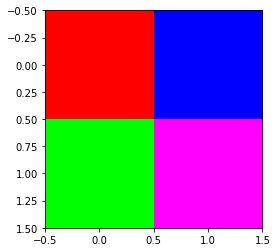

In [2]:
w = 1
h = 1

red = torch.Tensor([1, 0, 0])
green = torch.Tensor([0, 1, 0])
blue = torch.Tensor([0, 0, 1])
pink = torch.Tensor([1, 0, 1])

image = torch.zeros(3, w*2, h*2)
image[:, :w, :h] = red.view(-1, 1, 1)
image[:, w:, :h] = green.view(-1, 1, 1) 
image[:, :w, h:] = blue.view(-1, 1, 1) 
image[:, w:, h:] = pink.view(-1, 1, 1)

# image[:, :w, :h] = PALETTE[0].view(-1, 1, 1)
# image[:, w:, :h] = PALETTE[1].view(-1, 1, 1) 
# image[:, :w, h:] = PALETTE[4].view(-1, 1, 1) 
# image[:, w:, h:] = PALETTE[2].view(-1, 1, 1)

plt.imshow(image.permute(1, 2, 0))
plt.show()

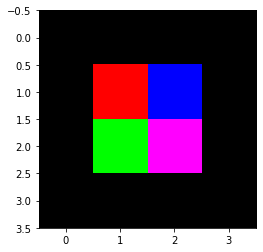

In [3]:
image_pad = torch.nn.ZeroPad2d(1)(image)

plt.imshow(image_pad.permute(1, 2, 0))
plt.show()

# Interpolate a single image with `torch.nn.functional.grid_sample`

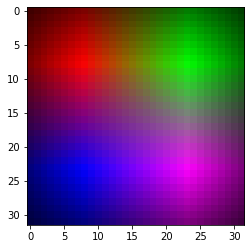

In [4]:
# Dense interpolation
res = 32
grid = torch.stack(torch.meshgrid(torch.linspace(-1, 1, res), torch.linspace(-1, 1, res))).permute(1, 2, 0).unsqueeze(0)
out = torch.nn.functional.grid_sample(image.unsqueeze(0), grid, align_corners=False).squeeze(0).squeeze(-1)

plt.imshow(out.permute(1, 2, 0))
plt.show()

In [5]:
# Sparse interpolation
grid_sparse = grid[:, np.random.choice(np.arange(res), 5), np.random.choice(np.arange(res), 5)].unsqueeze(2)
out_sparse = torch.nn.functional.grid_sample(image.unsqueeze(0), grid_sparse, align_corners=False).squeeze(0).squeeze(-1)

In [7]:
# Make sure that the sparse and dense interpolations match 
x, y = ((grid_sparse.squeeze() + 1) * res / 2).long().split(1, dim=1)
torch.equal(out[:, x.squeeze(), y.squeeze()], out_sparse)

True

This works fine for a single image but `torch.nn.functional.grid_sample` cannot be used to index mapped features from a batch of images, because the grid is expected to have the same size for each image. Unfortunately, in our case, the images receive mappings of uneven sizes. For that reason, we need to build our own sparse interpolation implementation. 

# Interpolate multiple images with different samplings

In [8]:
n_views = 10
n_images = 1

idx_image = torch.randint(0, n_images, (n_views,))
coords = torch.rand(n_views, 2)  # coordinates are pixel mappings converted to [0, 1]
images = torch.stack([image.clone() for _ in range(n_images)])

In [9]:
def interpolate(images, idx_image, coords):
    # Input pixels are expected to be float in [0, 1]

    device = images.device

    # Recover the image dimensions
    h, w = images.shape[2:]

    # Pad images with 0-feature
    images_pad = torch.nn.ZeroPad2d(1)(images)

    # Adapt [0, 1] coordinates to padded image coordinate system
    pixels = coords * torch.Tensor([[h, w]], device=device)

    # Compute the interpolation pixel coordinates: top-left, top-right, 
    # bottom-left, bottom-right
    pixels_tl = torch.stack((pixels[:, 0].floor(), pixels[:, 1].floor())).T.long()
    pixels_tr = torch.stack((pixels[:, 0].floor(), pixels[:, 1].ceil())).T.long()
    pixels_bl = torch.stack((pixels[:, 0].ceil(), pixels[:, 1].floor())).T.long()
    pixels_br = torch.stack((pixels[:, 0].ceil(), pixels[:, 1].ceil())).T.long()

    # Compute the weight associated with each interpolation point
    w_tl = torch.prod(pixels - pixels_br, dim=1).abs().unsqueeze(1)
    w_tr = torch.prod(pixels - pixels_bl, dim=1).abs().unsqueeze(1)
    w_bl = torch.prod(pixels - pixels_tr, dim=1).abs().unsqueeze(1)
    w_br = torch.prod(pixels - pixels_tl, dim=1).abs().unsqueeze(1)
    
    out = w_tl * images_pad[idx_image, :, pixels_tl[:, 0], pixels_tl[:, 1]] \
        + w_tr * images_pad[idx_image, :, pixels_tr[:, 0], pixels_tr[:, 1]] \
        + w_bl * images_pad[idx_image, :, pixels_bl[:, 0], pixels_bl[:, 1]] \
        + w_br * images_pad[idx_image, :, pixels_br[:, 0], pixels_br[:, 1]]
    
    return out

In [303]:
grid_sparse

tensor([[[[-0.3548,  0.1613]],

         [[ 0.9355,  0.2258]],

         [[ 0.2903,  0.8710]],

         [[-0.8065,  0.7419]],

         [[-0.3548,  0.9355]]]])

In [10]:
coords = (grid_sparse.squeeze() + 1) / 2
n_views = coords.shape[0]
idx_image = torch.zeros(n_views).long()
images = image.unsqueeze(0)

out_manual = interpolate(images, idx_image, coords)

In [287]:
out_manual

tensor([[0.5411, 0.0000, 0.1041],
        [0.2612, 0.7242, 0.2258],
        [0.3444, 0.0375, 0.8710],
        [0.0499, 0.0000, 0.1436],
        [0.0416, 0.0000, 0.6035]])

In [288]:
out_sparse.T

tensor([[0.3855, 0.5653, 0.1452],
        [0.4097, 0.0000, 0.5645],
        [0.4971, 0.1319, 0.4971],
        [0.0000, 0.5258, 0.0000],
        [0.0819, 0.4826, 0.0819]])

In [291]:
out.shape

torch.Size([3, 32, 32])

In [293]:
coords = torch.Tensor([[0, 0]])
n_views = coords.shape[0]
idx_image = torch.zeros(n_views).long()
images = image.unsqueeze(0)

out_manual = interpolate(images, idx_image, coords)

In [294]:
out_manual

tensor([[0., 0., 0.]])

In [298]:
coords

tensor([[0., 0.]])

In [300]:
out.shape

torch.Size([3, 32, 32])

In [297]:
out[:, (coords[:, 0] * res).long(), (coords[:, 1] * res).long()]

tensor([[0.2500],
        [0.0000],
        [0.0000]])

In [301]:
out[:, 0, 0]

tensor([0.2500, 0.0000, 0.0000])